In [ ]:
pip install yfinance --upgrade --no-cache-dir

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import math
from sklearn.ensemble import RandomForestClassifier
from datetime import date,timedelta

In [ ]:
today_date = date.today()
year_now = today_date.year
prev = int(year_now)-1
five_years_ago = today_date - timedelta(days=365*5)

In [ ]:
ticker_symbol = input("Input the ticker of stock ")

Input the ticker of stock KOTAKBANK.NS


In [ ]:
def get_stock_name(tick_symbol):
    stock = yf.Ticker(tick_symbol)
    stock_info = stock.info
    return stock_info['longName']

name = get_stock_name(ticker_symbol)

In [ ]:
data = yf.download(ticker_symbol, start=five_years_ago, end=today_date)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-30,1382.199951,1397.00,1351.050049,1386.550049,1383.142822,6210573
2019-05-02,1394.000000,1421.75,1382.500000,1406.349976,1402.894287,4780805
2019-05-03,1406.400024,1435.75,1400.199951,1417.800049,1414.316162,4269675
2019-05-06,1400.000000,1417.00,1399.699951,1410.400024,1406.934326,2109507
2019-05-07,1410.000000,1425.00,1399.250000,1408.150024,1404.689941,2786736


In [ ]:

# Calculate features
data['Open-Close'] = data['Close']
data['High-Low'] = data['High']
data['percent_change'] = data['Adj Close'].pct_change()
data['std_5'] = data['percent_change'].rolling(5).std()
data['ret_5'] = data['percent_change'].rolling(5).mean()

# Drop rows with missing values
data.dropna(inplace=True)

# Verify X contains features
X1 = data[['Open-Close', 'High-Low']]

y1 = np.where(data['High'].shift(-1) > data['Close'], 1, -1)

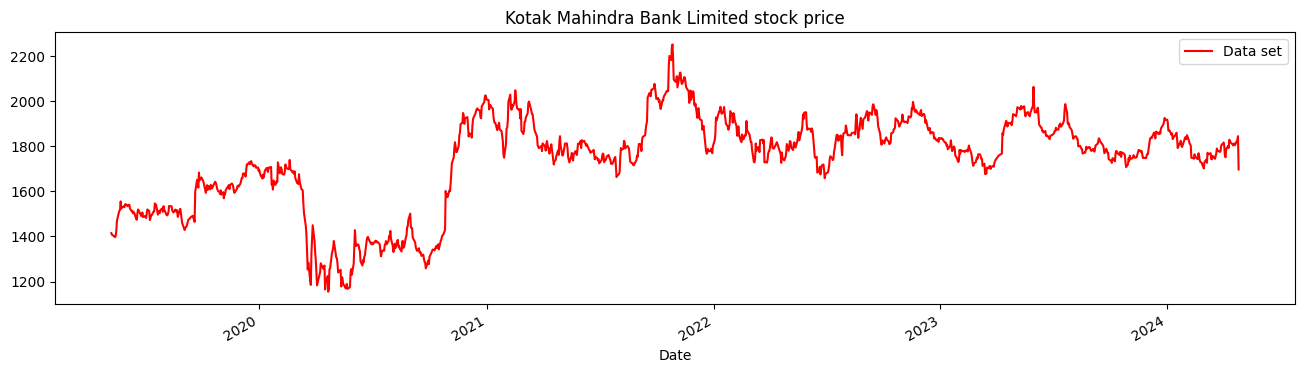

In [ ]:


import matplotlib.pyplot as plt

# Assuming you have already defined data, prev, year_now, and name

# Plot both training and test sets on the same plot
data["High"].plot(figsize=(16, 4), legend=True, color='red')
# data["High"][prev-1:].plot(figsize=(16, 4), legend=True, color='blue')

# Add legend
plt.legend(['Data set'])

# Add title
plt.title(name + " stock price")

# Show plot
plt.show()



In [ ]:
from sklearn.preprocessing import MinMaxScaler

training_set = data[:today_date].iloc[:, 1:2].values
# print(training_set)

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Assuming training_set_scaled is a numpy array
X_train = []
y_train = []

# Assuming training_set_scaled is a 2D array where the first column contains your data
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape X_train to fit the LSTM input shape (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))

regressor.compile(optimizer='nadam', loss='mean_squared_error')


In [ ]:
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
37/37 [==============================] - 30s 280ms/step - loss: 0.0350
Epoch 2/50
37/37 [==============================] - 6s 173ms/step - loss: 0.0134
Epoch 3/50
37/37 [==============================] - 4s 119ms/step - loss: 0.0112
Epoch 4/50
37/37 [==============================] - 5s 132ms/step - loss: 0.0113
Epoch 5/50
37/37 [==============================] - 5s 135ms/step - loss: 0.0110
Epoch 6/50
37/37 [==============================] - 4s 119ms/step - loss: 0.0102
Epoch 7/50
37/37 [==============================] - 5s 147ms/step - loss: 0.0092
Epoch 8/50
37/37 [==============================] - 4s 120ms/step - loss: 0.0091
Epoch 9/50
37/37 [==============================] - 4s 120ms/step - loss: 0.0087
Epoch 10/50
37/37 [==============================] - 5s 147ms/step - loss: 0.0082
Epoch 11/50
37/37 [==============================] - 4s 120ms/step - loss: 0.0078
Epoch 12/50
37/37 [==============================] - 5s 142ms/step - loss: 0.0078
Epoch 13/50
37/37 [=====

In [ ]:
# import pandas as pd

# pre-processing the data
dataset_total = pd.concat((data["High"][:prev-1], data["High"][prev:]))
inputs = dataset_total[len(dataset_total) - len(y_train) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs1 = sc.transform(inputs)

# making the test data
X_test = []
for i in range(60, len(inputs1)):
    X_test.append(inputs1[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

test_set = []
for i in range(60,len(inputs)):
  test_set.append(inputs[i])


predicted_stock_price_1 = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_1)
# print(predicted_stock_price)
close_prices = data["Close"].values[-len(predicted_stock_price):]


37/37 [==============================] - 3s 38ms/step


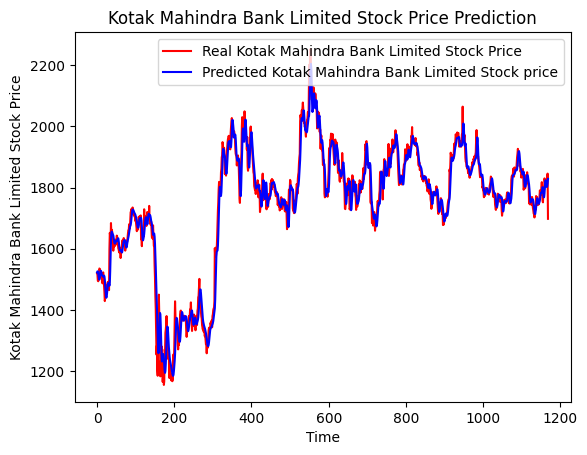

In [ ]:
def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real "+name+" Stock Price")
    plt.plot(prediction, color="blue", label="Predicted " + name + " Stock price")
    plt.title(name+" Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel(name+" Stock Price")
    plt.legend()
    plt.show()
# now we'll use this function to visualize our test and predicted data

plot_prediction(test_set,predicted_stock_price)

In [ ]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

print(mse(test_set, predicted_stock_price))

1574.070133590808


In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mse(test,predicted))
    print("The root mean squared error is {}.".format(rmse))

return_rmse(test_set,predicted_stock_price)

The root mean squared error is 39.67455272074038.


In [ ]:
dataset_length = data.shape[0]

split = int(dataset_length * 0.50)
X_train = X1[:split]
y_train = y1[:split]
print(X_train)


             Open-Close     High-Low
Date                                
2019-05-08  1402.199951  1414.900024
2019-05-09  1385.500000  1407.900024
2019-05-10  1398.150024  1406.500000
2019-05-13  1389.349976  1399.750000
2019-05-14  1382.949951  1397.000000
...                 ...          ...
2021-10-21  2143.750000  2155.000000
2021-10-22  2171.399902  2201.649902
2021-10-25  2154.500000  2182.949951
2021-10-26  2210.949951  2240.000000
2021-10-27  2188.250000  2253.000000

[614 rows x 2 columns]


In [ ]:
clf = RandomForestClassifier()

In [ ]:
features = np.column_stack((close_prices, predicted_stock_price))

last_row_index = -1  # Last row index
tomorrow_high_price = features[last_row_index, 1]  # Tomorrow's high price is the second column of the last row
today_close_price = features[last_row_index, 0]
# Define the output variable based on the condition
output_variable = np.where(tomorrow_high_price > today_close_price, 1, -1)

model = clf.fit(X_train, y_train)

rf_predicted = clf.predict(features)

print("Random Forest predicted:", rf_predicted)



Random Forest predicted: [1 1 1 ... 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
predicted_stock_price_flat = predicted_stock_price.flatten()

# Convert the flattened array to a pandas Series
predicted_stock_price_series = pd.Series(predicted_stock_price_flat)

# Calculate the percent change
percent_change = predicted_stock_price_series.pct_change()
percent_change.dropna(inplace=True)
percent_change_array = percent_change.values



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


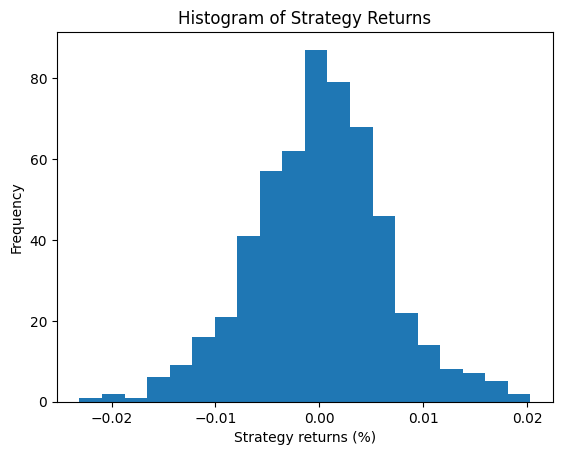

In [ ]:
#Plot strategy returns
close_prices_sliced = close_prices[1:]
predicted_stock_price_sliced = predicted_stock_price[1:]

# Stack the sliced arrays column-wise
features1 = np.column_stack((close_prices_sliced, predicted_stock_price_sliced))
strategy_returns_array = percent_change_array * model.predict(features1)

plt.hist(strategy_returns_array[split:], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Strategy returns (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Strategy Returns')
plt.show()


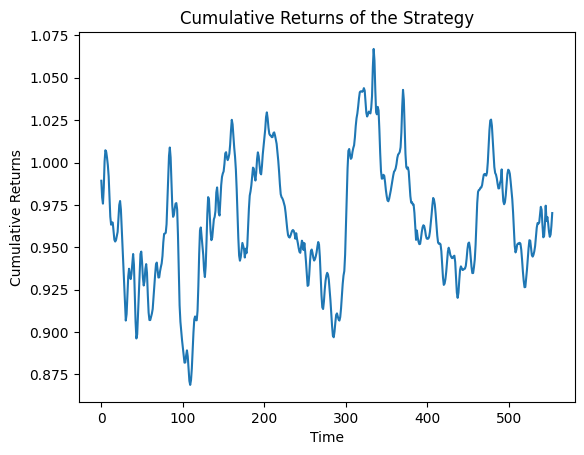

In [ ]:
# Calculate the cumulative returns of the strategy
cumulative_returns_series = pd.Series((strategy_returns_array[split:] + 1).cumprod())

# Plot the cumulative returns
cumulative_returns_series.plot()
plt.ylabel('Cumulative Returns')
plt.xlabel('Time')
plt.title('Cumulative Returns of the Strategy')
plt.show()